In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

mpl.rcParams['font.size'] = 100
sns.set_context("paper", font_scale=2)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams['image.cmap'] = 'viridis'

In [2]:
def create_toy_data(func, n=10, std=1., domain=[0., 1.]):
    x = np.linspace(domain[0], domain[1], n)
    t = func(x) + np.random.normal(scale=std, size=n)
    return x, t

def sinusoidal(x):
        return np.sin(2 * np.pi * x)

def normalize(x, kmin, kmax):
    return (x-kmin)/(kmax-kmin)

In [3]:
def relu_kernel(x, y, depth=2, weight_var=2.0, bias_var=0.001, mu_2=1.0, same=False):
    if same:
        k_aa = 0.5*weight_var*x*x*mu_2 + bias_var
        for _ in range(depth):
            k_aa = 0.5*weight_var*k_aa*mu_2 + bias_var
        return k_aa
    else:
        k_ab = 0.5*weight_var*x*y + bias_var
        k_aa = 0.5*weight_var*x*x*mu_2 + bias_var
        k_bb = 0.5*weight_var*y*y*mu_2 + bias_var
        c_ab = np.round(k_ab/np.sqrt(k_aa*k_bb), 8)
        theta_ab = np.arccos(c_ab)
        for _ in range(depth):
            k_ab = (weight_var/(2*np.pi))*np.sqrt(k_aa*k_bb)*(np.sin(theta_ab) + (np.pi - theta_ab)*np.cos(theta_ab)) + bias_var
            k_aa = 0.5*weight_var*k_aa*mu_2 + bias_var
            k_bb = 0.5*weight_var*k_bb*mu_2 + bias_var
            c_ab = np.round(k_ab/(np.sqrt(k_aa)*np.sqrt(k_bb)), 8)
            theta_ab = np.arccos(c_ab)
        return k_ab

In [4]:
def plot_nngp_fit(ax, x_train, y_train, d, mu2, sig_b, offset): 

    N = len(x_train)
    x = np.linspace(-0.5, 0.5, 100)
    sig_w = 2/mu2 + offset

    # Compute kernel
    K = np.zeros((N, N))
    for i in range(len(x_train)):
        for j in range(len(x_train)):
            if i < j:
                K[i,j] = relu_kernel(x_train[i], x_train[j], depth=d, weight_var=sig_w, bias_var=sig_b, mu_2=mu2)
                K[j,i] = K[i,j]
            if i == j:
                K[i,i] = relu_kernel(x_train[i], x_train[j], depth=d, 
                                     weight_var=sig_w, bias_var=sig_b, mu_2=mu2, same=True)

    
    noise_var = 0.001
    covariance = K + noise_var*np.ones((N, N))
    inv_cov = np.linalg.inv(covariance)
    t = y_train + noise_var

    # make predictions
    k = np.zeros((N,))
    y = np.zeros(len(x))
    y_std = np.zeros(len(x))
    for i, p in enumerate(x):
        c = relu_kernel(p, p, depth=d, weight_var=sig_w, bias_var=sig_b, mu_2=mu2, same=True)
        for j, x_t in enumerate(x_train):
            k[j] = relu_kernel(p, x_t, depth=d, weight_var=sig_w, bias_var=sig_b, mu_2=mu2)
        y[i] = np.dot(np.transpose(k), inv_cov).dot(t)
        y_std[i] = np.sqrt(c - np.transpose(k).dot(inv_cov).dot(k))
    
    ax.scatter(x_train, y_train, edgecolor="b", color="steelblue", label="training", s=100)
    ax.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
    ax.plot(x, y, color="r", label="gpr")
    ax.fill_between(x, y - y_std, y + y_std, alpha=0.5, color="pink", label="std")

### Samples from noisy NNGP prior as a function of the noise

In [5]:
num_points = 100
mu2 = 1.0
w = 2/mu2
b = 0.05 # 0.000001
d = 20
x = np.linspace(-3, 3, num_points)
K1 = np.zeros((len(x), len(x)))
for i in range(len(x)):
    for j in range(len(x)):
        if i < j:
            K1[i,j] = relu_kernel(x[i], x[j], depth=d, weight_var=w, bias_var=b, mu_2=mu2)
            K1[j,i] = K1[i,j]
        if i == j:
            K1[i,i] = relu_kernel(x[i], x[i], depth=d, weight_var=w, bias_var=b, mu_2=mu2, same=True)
        

mu2 = 1.001
w = 2/mu2
K2 = np.zeros((len(x), len(x)))
for i in range(len(x)):
    for j in range(len(x)):
        if i < j:
            K2[i,j] = relu_kernel(x[i], x[j], depth=d, weight_var=w, bias_var=b, mu_2=mu2)
            K2[j,i] = K2[i,j]
        if i == j:
            K2[i,i] = relu_kernel(x[i], x[i], depth=d, weight_var=w, bias_var=b, mu_2=mu2, same=True)
    
mu2 = 2.0
w = 2/mu2
K3 = np.zeros((len(x), len(x)))
for i in range(len(x)):
    for j in range(len(x)):
        if i < j:
            K3[i,j] = relu_kernel(x[i], x[j], depth=d, weight_var=w, bias_var=b, mu_2=mu2)
            K3[j,i] = K3[i,j]
        if i == j:
            K3[i,i] = relu_kernel(x[i], x[i], depth=d, weight_var=w, bias_var=b, mu_2=mu2, same=True)

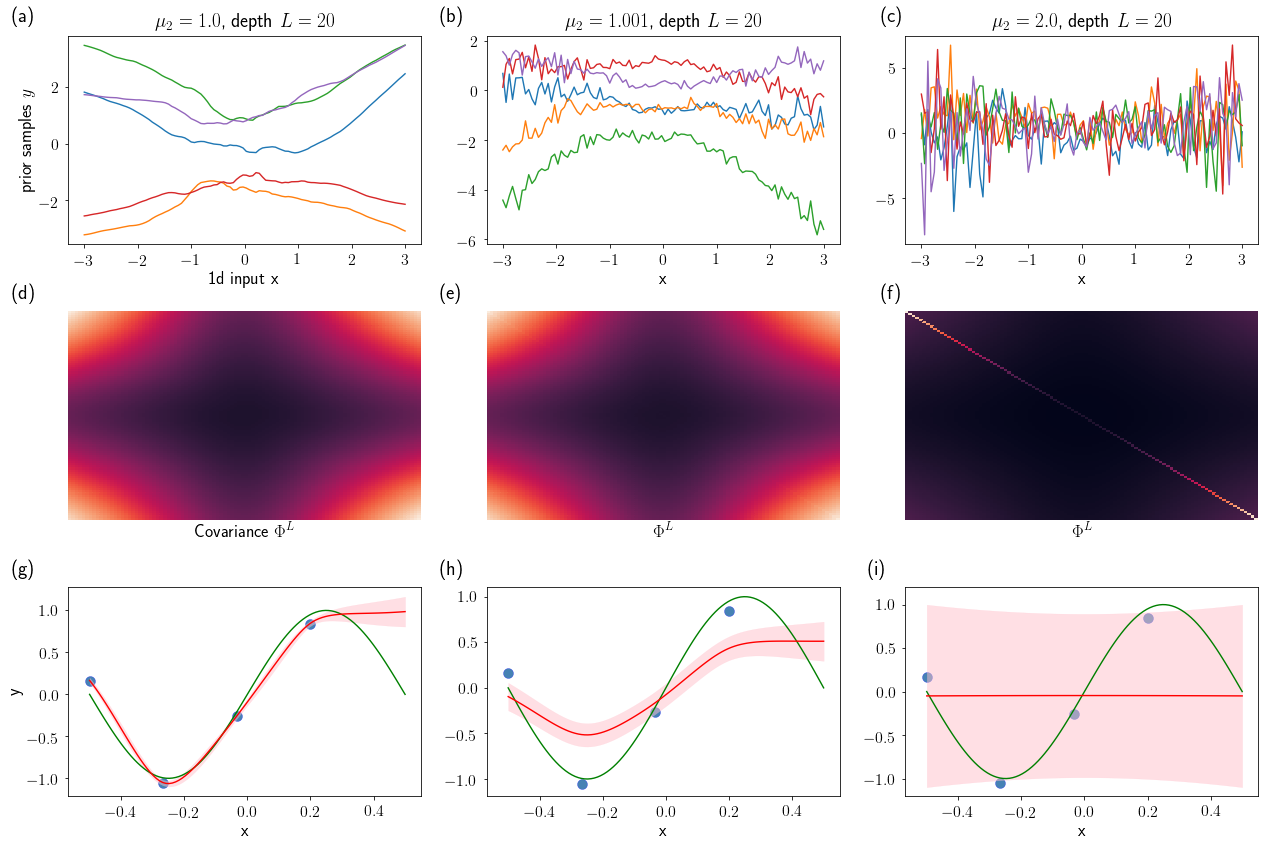

In [6]:
np.random.seed(2)
fig, [[ax1, ax2, ax3],[ax4, ax5, ax6], [ax7, ax8, ax9]] = plt.subplots(3, 3, figsize=(18, 12))
top = [ax1, ax2, ax3]
bottom = [ax4, ax5, ax6]
kernels = [np.round(K1, 8), np.round(K2, 8), np.round(K3, 8)]
k_max = np.max([np.max(x) for x in kernels])
k_min = np.min([np.min(x) for x in kernels])
x = np.linspace(-3, 3, num_points)
num_samples = 5
count = 0
for K in kernels:
    for _ in range(num_samples):
        y = np.random.multivariate_normal(np.zeros((len(x),)), K)
        top[count].plot(x, y)
        plt.ylim(-6, 6)
    sns.heatmap(K, ax=bottom[count], rasterized=True, vmin=k_min, vmax=k_max, cbar=False)
    bottom[count].set_xticks([],[])
    bottom[count].set_yticks([],[])
    count += 1

ax1.set_title(r'$\mu_2 = 1.0$, depth $L=20$')
ax1.set_xlabel('1d input x')
ax1.set_ylabel(r'prior samples $y$')
ax2.set_title(r'$\mu_2 = 1.001$, depth $L=20$')
ax2.set_xlabel('x')
ax3.set_title(r'$\mu_2 = 2.0$, depth $L=20$')
ax3.set_xlabel('x')
ax4.set_xlabel(r'Covariance $\Phi^L$')
ax5.set_xlabel(r'$\Phi^L$')
ax6.set_xlabel(r'$\Phi^L$')
fig.text(0.02, 0.97, "(a)", fontsize=20)
fig.text(0.35, 0.97, "(b)", fontsize=20)
fig.text(0.69, 0.97, "(c)", fontsize=20)
fig.text(0.02, 0.65, "(d)", fontsize=20)
fig.text(0.35, 0.65, "(e)", fontsize=20)
fig.text(0.69, 0.65, "(f)", fontsize=20)

np.random.seed(1)
n=4
x_train, y_train = create_toy_data(sinusoidal, n=n, std=0.1, domain=[-0.5, 0.2])

# parameter settings
d=20
b=0.05 #0.005

# plot fits
plot_nngp_fit(ax7, x_train, y_train, d=d, mu2=1.0, sig_b=b, offset=0)
plot_nngp_fit(ax8, x_train, y_train, d=d, mu2=1.001, sig_b=b, offset=0)
plot_nngp_fit(ax9, x_train, y_train, d=d, mu2=2.0, sig_b=b, offset=0)
ax7.set_xlabel('x')
ax8.set_xlabel('x')
ax9.set_xlabel('x')
ax7.set_ylabel('y')
ax9.set_ylim(-1.2, 1.2)

fig.text(0.02, 0.33, "(g)", fontsize=20)
fig.text(0.35, 0.33, "(h)", fontsize=20)
fig.text(0.68, 0.33, "(i)", fontsize=20)

plt.gcf().tight_layout()
plt.show()